In [1]:
%cd ~/aiffel/Aiffelthon_koBART
!pip install -r requirements.txt

/aiffel/aiffel/Aiffelthon_koBART


In [22]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7624228054291478088,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14474280960
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12658721876194458159
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [23]:
import argparse
import logging
import os
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from pytorch_lightning import loggers as pl_loggers
from torch.utils.data import DataLoader, Dataset
from dataset import KobartSummaryModule
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast
from transformers.optimization import AdamW, get_cosine_schedule_with_warmup


In [27]:
# %cd ~/aiffel/Aiffelthon_koBART/data
# !unzip ~/aiffel/Aiffelthon_koBART/data/train_20per_onesetn.zip
# !unzip ~/aiffel/Aiffelthon_koBART/data/val_20per_onesetn.zip

/aiffel/aiffel/Aiffelthon_koBART/data
Archive:  /aiffel/aiffel/Aiffelthon_koBART/data/train_20per_onesetn.zip
  inflating: train_20per.csv         
Archive:  /aiffel/aiffel/Aiffelthon_koBART/data/val_20per_onesetn.zip
  inflating: val_20per.csv           


In [3]:
tokenizer = PreTrainedTokenizerFast.from_pretrained('gogamza/kobart-base-v1')
model = BartForConditionalGeneration.from_pretrained('gogamza/kobart-base-v1')

Downloading:   0%|          | 0.00/4.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/111 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473M [00:00<?, ?B/s]

In [4]:
train_df = pd.read_csv('~/aiffel/Aiffelthon_koBART/data/train_20per.csv')
train_df.head()

Unnamed: 0                                     input_documant  \
0           0   지어내버린 대목부터는 흥분이 버썩 줄어지었다 ──. "선생님! 또 기침이 나고 토...   
1           1   이 송아지가 젖을 떼우고 집으로 끌고 오던 날은 첨지는 개선장군이 성안 에 들어올...   
2           2   어떤 여름날 밤 손주딸에게 관한 불길한 꿈을 꾼 이 한머니는 이튿날 조반 후에 생...   
3           3   이러한 가운데서 왕후는 자기의 입장을 위태롭게 여기고 겸하여 장래 자기 의 몸으로...   
4           4   “가겠소.” “언니가 나오시면 일러드 리겠으니 그때까지는 찾아오지 않으시는 것이 ...   

                                        sentence_20%  
0  자신을 배반한 제 계집과 세상이 엎드려 죄 사하기를 빌 때까지 죽지 아니하겠다는 H...  
1  젖뗀 송아지를 집으로 끌고 오던 날 어깨춤을 추면서 소 들어간다고 고함을 지르는 첨...  
2  손주딸의 관한 불길한 꿈을 꾼 한머니는 백여 리 떨어진 손주딸의 집에를 가보기로 하...  
3  자기는 태자의 위를 동경하거나 부러워한 적이 없으며 이 나라의 충성된 신자로서 공주...  
4  자신의 신변을 염려하여 빠른 걸음으로 골목을 빠져나와 침착한 의식을 회복하면서 어수...

In [5]:
test_df = pd.read_csv('~/aiffel/Aiffelthon_koBART/data/val_20per.csv')
test_df.head()

Unnamed: 0                                     input_documant  \
0           0   러시아 황실이 제공한 임시공관에서 오전 내내 쉬며 지냈다. 오늘 아침 우리 임시공...   
1           1  위에서 살펴본 방법으로 배우자 공제건수를 종합소득과 근로소득의 경우로 나누어 추정하...   
2           2  우리나라 공공기관의 현황 분석을 시작으로 공공기관을 체계적으로 평가하기 시작하였다....   
3           3   그런 점에서 볼 때, 박영민씨 경우는 이례적인 케이스로 꼽힌다. 프로게이머 특성상...   
4           4  도로명 주소는 지번 주소에 비해 위치 파악 시 더 많은 범위를 탐색해야 하는 단점을...   

                                        sentence_20%  
0  러시아에서 제공한 임시공관에서 쉬면서 아침에 태극기를 발코니 위에 게양했는데 모스크...  
1  기본공제액 확대 시 배우자 기본공제액 확대에 따른 공제 규모 증가분에 평균 실효세율...  
2  공공기관 정부 지원 예산안 평가에서는 일부 공공기관들이 여유자금을 과다하게 보유하고...  
3  박 씨는 기초 지식이 부족해 영어 문답을 통째로 외우다시피 하며 공무원 시험 준비를...  
4  도로명 주소는 지번 주소에 비해 위치 파악 시 더 많은 범위를 탐색해야 하는 점이 ...

In [6]:
train_df.drop(labels = 'Unnamed: 0', axis=1, inplace=True)
test_df.drop(labels = 'Unnamed: 0', axis=1, inplace=True)

In [7]:
test_df.head()

input_documant  \
0   러시아 황실이 제공한 임시공관에서 오전 내내 쉬며 지냈다. 오늘 아침 우리 임시공...   
1  위에서 살펴본 방법으로 배우자 공제건수를 종합소득과 근로소득의 경우로 나누어 추정하...   
2  우리나라 공공기관의 현황 분석을 시작으로 공공기관을 체계적으로 평가하기 시작하였다....   
3   그런 점에서 볼 때, 박영민씨 경우는 이례적인 케이스로 꼽힌다. 프로게이머 특성상...   
4  도로명 주소는 지번 주소에 비해 위치 파악 시 더 많은 범위를 탐색해야 하는 단점을...   

                                        sentence_20%  
0  러시아에서 제공한 임시공관에서 쉬면서 아침에 태극기를 발코니 위에 게양했는데 모스크...  
1  기본공제액 확대 시 배우자 기본공제액 확대에 따른 공제 규모 증가분에 평균 실효세율...  
2  공공기관 정부 지원 예산안 평가에서는 일부 공공기관들이 여유자금을 과다하게 보유하고...  
3  박 씨는 기초 지식이 부족해 영어 문답을 통째로 외우다시피 하며 공무원 시험 준비를...  
4  도로명 주소는 지번 주소에 비해 위치 파악 시 더 많은 범위를 탐색해야 하는 점이 ...

In [8]:
print('전체 샘플 수 :', len(train_df['input_documant']))
print('전체 샘플 수 :', len(train_df['sentence_20%']))

전체 샘플 수 : 73431
전체 샘플 수 : 73431


text_len의 최소 길이 : 67
text_len의 최대 길이 : 404
text_len의 평균 길이 : 188.93805068703952
headlines_len의 최소 길이 : 3
headlines_len의 최대 길이 : 30
headlines_len의 평균 길이 : 17.836336152306245


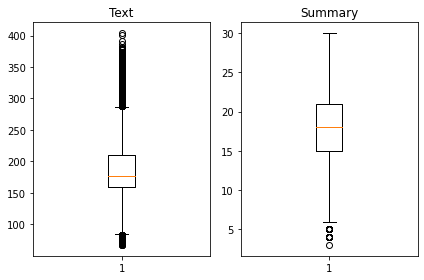

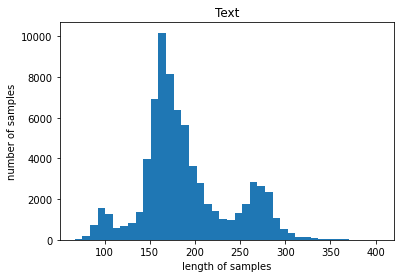

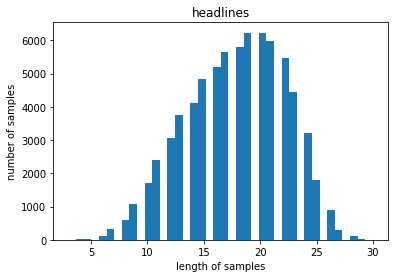

In [9]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in train_df['input_documant']]
headlines_len = [len(s.split()) for s in train_df['sentence_20%']]

print('text_len의 최소 길이 : {}'.format(np.min(text_len)))
print('text_len의 최대 길이 : {}'.format(np.max(text_len)))
print('text_len의 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines_len의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines_len의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines_len의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [10]:
pad_token_id= tokenizer.pad_token_id
pad_token_id

3

In [11]:
train_df = train_df.dropna(axis=0)

In [12]:
text = """
1일 오후 9시까지 최소 20만3220명이 코로나19에 신규 확진됐다. 또다시 동시간대 최다 기록으로, 사상 처음 20만명대에 진입했다.
방역 당국과 서울시 등 각 지방자치단체에 따르면 이날 0시부터 오후 9시까지 전국 신규 확진자는 총 20만3220명으로 집계됐다.
국내 신규 확진자 수가 20만명대를 넘어선 것은 이번이 처음이다.
동시간대 최다 기록은 지난 23일 오후 9시 기준 16만1389명이었는데, 이를 무려 4만1831명이나 웃돌았다. 전날 같은 시간 기록한 13만3481명보다도 6만9739명 많다.
확진자 폭증은 3시간 전인 오후 6시 집계에서도 예견됐다.
오후 6시까지 최소 17만8603명이 신규 확진돼 동시간대 최다 기록(24일 13만8419명)을 갈아치운 데 이어 이미 직전 0시 기준 역대 최다 기록도 넘어섰다. 역대 최다 기록은 지난 23일 0시 기준 17만1451명이었다.
17개 지자체별로 보면 서울 4만6938명, 경기 6만7322명, 인천 1만985명 등 수도권이 12만5245명으로 전체의 61.6%를 차지했다. 서울과 경기는 모두 동시간대 기준 최다로, 처음으로 각각 4만명과 6만명을 넘어섰다.
비수도권에서는 7만7975명(38.3%)이 발생했다. 제주를 제외한 나머지 지역에서 모두 동시간대 최다를 새로 썼다.
부산 1만890명, 경남 9909명, 대구 6900명, 경북 6977명, 충남 5900명, 대전 5292명, 전북 5150명, 울산 5141명, 광주 5130명, 전남 4996명, 강원 4932명, 충북 3845명, 제주 1513명, 세종 1400명이다.
집계를 마감하는 자정까지 시간이 남아있는 만큼 2일 0시 기준으로 발표될 신규 확진자 수는 이보다 더 늘어날 수 있다. 이에 따라 최종 집계되는 확진자 수는 21만명 안팎을 기록할 수 있을 전망이다.
한편 전날 하루 선별진료소에서 이뤄진 검사는 70만8763건으로 검사 양성률은 40.5%다. 양성률이 40%를 넘은 것은 이번이 처음이다. 확산세가 계속 거세질 수 있다는 얘기다.
이날 0시 기준 신규 확진자는 13만8993명이었다. 이틀 연속 13만명대를 이어갔다.
"""

text = text.replace('\n', ' ')

raw_input_ids = tokenizer.encode(text)
input_ids = [tokenizer.bos_token_id] + raw_input_ids + [tokenizer.eos_token_id]

summary_ids = model.generate(torch.tensor([input_ids]),  num_beams=4,  max_length=512,  eos_token_id=1)
tokenizer.decode(summary_ids.squeeze().tolist(), skip_special_tokens=True)


''

In [78]:
train_df['input_documant']

0         지어내버린 대목부터는 흥분이 버썩 줄어지었다 ──. "선생님! 또 기침이 나고 토...
1         이 송아지가 젖을 떼우고 집으로 끌고 오던 날은 첨지는 개선장군이 성안 에 들어올...
2         어떤 여름날 밤 손주딸에게 관한 불길한 꿈을 꾼 이 한머니는 이튿날 조반 후에 생...
3         이러한 가운데서 왕후는 자기의 입장을 위태롭게 여기고 겸하여 장래 자기 의 몸으로...
4         “가겠소.” “언니가 나오시면 일러드 리겠으니 그때까지는 찾아오지 않으시는 것이 ...
                               ...                        
73426    국민권익위원회 부패방지국 보호보상과장입니다. 부패신고 보상금 지급결정에 대해서 간단...
73427    반갑습니다. 지금 막 총리 주재 국무회의가 끝났습니다. 오늘 대통령령안이 19건, ...
73428    법무부 장관입니다. 지금부터 광복 71주년 특별사면과 행정제재 감면 조치에 관하여 ...
73429    먼저, 코로나19 변이와 관련해서 사실 소위 RNA 바이러스 자체가 변이가 상당히 ...
73430    예, 제가 아까 제일 모두에 처음 말씀드린 답변 중에 그런 일부 답변이 들어있었던 ...
Name: input_documant, Length: 73431, dtype: object

In [15]:
# pad_index = tokenizer.pad_token_id
# 이거는 위에서 분석한 내용으로 지정해야할 듯
def add_padding_data(inputs, max_len):
        pad_index = tokenizer.pad_token_id
        if len(inputs) < max_len:
            pad = np.array([pad_index] *(max_len - len(inputs)))
            inputs = np.concatenate([inputs, pad])
        else:
            inputs = inputs[:max_len]

        return inputs 
    ## max_len, pad_len을 구해야함

In [16]:
# 테스트
input_ids = add_padding_data(tokenizer.encode(train_df['input_documant'][0].replace('\n', ' ')), max_len)
input_ids

array([20681,  9517, 20860, 21368, 18059, 15768, 16217, 14536, 11528,
       18396, 12332, 22145,  1700, 15945,   245, 14050, 24515,  9743,
         232, 14153, 14040, 12875, 12034, 27930, 14521, 13673, 12034,
       26354, 14562, 14381, 18112,   232, 16530, 17882, 14042, 14083,
       11264, 14707, 14674, 12332, 14202, 14642, 15170, 15995, 14417,
       16009, 16526, 16389, 14203, 10773, 13590, 14060, 14158, 12344,
        9120, 16389, 14299, 14513, 14060, 14115, 16663, 22166, 14067,
       16624, 25376, 26303, 19951, 16647, 10313, 16426, 14031, 21443,
       15739, 18526, 16530, 17704, 17704, 14674, 12332, 14202, 13586,
       10322, 14562,   233, 14651, 14025, 22844, 14971,  9698, 24009,
       14523, 15764, 23046, 22794, 15400, 16391, 10443, 18941, 13594,
       14121,  1700, 14321, 28943, 16767, 14161, 20067, 15400,   243,
       14664, 12024, 14074, 18821, 15706, 10884, 16402, 29620, 14246,
       15636, 27043, 14955, 14651, 15420, 16391, 14120, 20866, 14058,
       14452, 14082,

In [17]:
len(train_df['input_documant'])

73431

In [ ]:
from tqdm import tqdm
input_ids = []
max_len = 404 
for i in tqdm(range(len(train_df['input_documant']))):
    input_ids.append(add_padding_data(tokenizer.encode(train_df['input_documant'][i]), max_len))
    
 
print(input_ids)

100%|██████████| 73431/73431 [01:23<00:00, 880.97it/s] 


In [24]:
input_ids

[array([20681,  9517, 20860, 21368, 18059, 15768, 16217, 14536, 11528,
        18396, 12332, 22145,  1700, 15945,   245, 14050, 24515,  9743,
          232, 14153, 14040, 12875, 12034, 27930, 14521, 13673, 12034,
        26354, 14562, 14381, 18112,   232, 16530, 17882, 14042, 14083,
        11264, 14707, 14674, 12332, 14202, 14642, 15170, 15995, 14417,
        16009, 16526, 16389, 14203, 10773, 13590, 14060, 14158, 12344,
         9120, 16389, 14299, 14513, 14060, 14115, 16663, 22166, 14067,
        16624, 25376, 26303, 19951, 16647, 10313, 16426, 14031, 21443,
        15739, 18526, 16530, 17704, 17704, 14674, 12332, 14202, 13586,
        10322, 14562,   233, 14651, 14025, 22844, 14971,  9698, 24009,
        14523, 15764, 23046, 22794, 15400, 16391, 10443, 18941, 13594,
        14121,  1700, 14321, 28943, 16767, 14161, 20067, 15400,   243,
        14664, 12024, 14074, 18821, 15706, 10884, 16402, 29620, 14246,
        15636, 27043, 14955, 14651, 15420, 16391, 14120, 20866, 14058,
      

In [41]:
label_ids = []
for i in range(2):
    label_ids.append(tokenizer.encode(train_df['sentence_20%'][i]))
    label_ids.append(tokenizer.eos_token_id)
    label_ids
label_ids

[[16751,
  14203,
  10773,
  13590,
  14060,
  14158,
  12344,
  9120,
  25403,
  25376,
  26303,
  16426,
  14031,
  21443,
  15739,
  17476,
  14674,
  12332,
  14202,
  16608,
  16391,
  12024,
  22844,
  14971,
  14651,
  15420,
  14452,
  14082,
  15164,
  14324,
  17710,
  14130],
 1,
 [19326,
  10094,
  14789,
  11696,
  14404,
  20293,
  18399,
  14075,
  9810,
  14456,
  18066,
  12795,
  12007,
  14170,
  14125,
  14081,
  19421,
  14117,
  14068,
  16174,
  14034,
  14830,
  17305,
  15621,
  14375,
  14688,
  14581,
  16290,
  14110,
  12060,
  14163,
  14117,
  16430,
  14486,
  14321,
  14568,
  18332],
 1]

In [38]:

label_ids

[[16751,
  14203,
  10773,
  13590,
  14060,
  14158,
  12344,
  9120,
  25403,
  25376,
  26303,
  16426,
  14031,
  21443,
  15739,
  17476,
  14674,
  12332,
  14202,
  16608,
  16391,
  12024,
  22844,
  14971,
  14651,
  15420,
  14452,
  14082,
  15164,
  14324,
  17710,
  14130],
 1,
 1]

In [31]:
dec_input_ids = [tokenizer.eos_token_id]
dec_input_ids

[1]

In [32]:
dec_input_ids += label_ids[:-1]
dec_input_ids 

[1,
 16751,
 14203,
 10773,
 13590,
 14060,
 14158,
 12344,
 9120,
 25403,
 25376,
 26303,
 16426,
 14031,
 21443,
 15739,
 17476,
 14674,
 12332,
 14202,
 16608,
 16391,
 12024,
 22844,
 14971,
 14651,
 15420,
 14452,
 14082,
 15164,
 14324,
 17710,
 14130]

In [49]:

def add_ignored_data(inputs, max_len, ignore_index):
        print('max_len', max_len)
        print('ignore_index', ingnore_index)
        if len(inputs) < max_len:
            pad = np.array([ignore_index] *(max_len - len(inputs)))
            inputs = np.concatenate([inputs, pad])
        else:
            inputs = inputs[:max_len]

        return inputs

In [52]:
max_len = 30
ignore_index = -100
label_ids.append(add_ignored_data(label_ids), 30, -100)

TypeError: add_ignored_data() missing 2 required positional arguments: 'max_len' and 'ignore_index'

In [45]:
label_ids = []
dec_input_ids = []
max_len = 30
ignore_index = -100
for i in tqdm(range(len(train_df['sentence_20%']))):
    label_ids.append(tokenizer.encode(train_df['sentence_20%'][i]))
    label_ids.append(tokenizer.eos_token_id)
    dec_input_ids = [tokenizer.eos_token_id]
    dec_input_ids += label_ids[:-1]
    dec_input_ids.append(add_padding_data(dec_input_ids, max_len))
    label_ids.append(add_ignored_data(label_ids), max_len, ignore_index)
    
 
print(input_ids)

  0%|          | 0/73431 [00:00<?, ?it/s]


TypeError: add_ignored_data() missing 2 required positional arguments: 'max_len' and 'ignore_index'

In [48]:
# def transform(data):
#     return tokenizer(
#       train_df['input_documant'],
#       truncation = True,
#       padding = 'max_length',
#       return_token_type_ids = False,
#     )
  
# examples = train_df[:5]
# examples_transformed = transform(examples)

# print(examples)
# # print(examples_transformed)

ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [38]:
from transformers import PreTrainedTokenizerFast, BartModel

tokenizer = PreTrainedTokenizerFast.from_pretrained('gogamza/kobart-base-v1')
model = BartModel.from_pretrained('gogamza/kobart-base-v1')

Downloading:   0%|          | 0.00/473M [00:00<?, ?B/s]